In [363]:
import numpy as np
import pandas as pd
import os
import random
import pathlib
import urllib.request
from random import shuffle
from datetime import date, time
# if this cell raises an ImportError, you should install `ipywidgets`
from ipywidgets import interact, FloatSlider

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rc('figure', dpi=100, figsize=(8, 5))
plt.rc('font', size=12)

# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
The dataset that we are using recorded the major electricity outage that occured in the US continent with different variables that might be related to the electricity outage and effects that brought with it. There are around 1500 cases of the electricity outage between 2000 and 2016. The main goal of our project is to analysis the given dataset. Our group are trying to find out if the cold climate catergory is related to the longer duration of the outage.
The three main part of this project is cleaning data, assessing missingness of the dataset and hypothesis testing. 

### Cleaning and EDA
After we downloaded the dataset of outage, we followed the instructions in the writeup which combining the columns of 
['OUTAGE.START.DATE'] and ['OUTAGE.START.TIME'] into a new column of ['OUTAGE.START']. We first change the object into string and combined them together then tranfered it into datetime. Then we replaced the np.nan with the date of '1770-01-01 01:01:01' to aviod error it np.nan can cause and it is very easy to locate. Then we replace the datetime of '1770-01-01 01:01:01' with np.nan. We did the same thing for the [OUTAGE.RESTORATION.DATE],[OUTAGE.RESTORATION.TIME] and combined them into column of ['OUTAGE.RESTORATION']. After teh combining, we droped the old columns inorder to reduce confusion. We noticed that some of the duration values are 0, so we manually replaced the zero value with np.nan.

#### EDA
I used .shape to find out the total amount of columns and rows in our outage dataset. There are 1534 rows and 55 columns, which means that out dataset contains 1524 electricity outage incident. The we used .info() to check the columns and their corresponding data types,along with finding whether they contain null values or not. most of the variables have the object datatype, and the outage start and end columns are datetime datatype. Then we used .describe to see the amount of unique values in each columns. In order to find out our answer of our hypothesis question, we narrowed down to the duration and climate caterogy columns. THe most common value that occured in duration is 1.0 min with frequency of 97. The most common value for climate category is normal with frequency of 744. 

we chose to perform univariate analysis on the variable OUTAGE DURATION. We used histogram to show how the duaration of outage distributed. From the histogram that we plot, we see that the distribution of the ourtage duration is right skewed, which means the it is more often to see outage with short duration.  

We used OUTAGE DURATION, CLIMATE CATEGORY to perform out bivariate Analysis. We used scatter plot to see the relationship between these two columns. Since the duration variable are so variant, the scatter plot seem to be all gathered and it's hard to tell the details. We zoomed in a little and set the y limit at only the first hundred values, and the normal climate have more density with more scatter dots in the plot. Since the scatter plot isn't fully showing what we want, we created a pivot table. We used the climate category instead of the month for this time. Since there are too many values for the outage, we decided to cut them into bins. We made a pivot table out of the bins of duration and counted the number of outage occured within each climate category. Then we ploted the our pivot table to see if any kinds of the climate category have relationship with the duration.  

To perform the aggregate analysis, we grouped the data by climate category and trying to find out if outage duration is related to the individual climate. We plot out our groupby and the normal climate seem have bigger frequency than others. On the contrary, when we set the density equal to True, warm climate have the highest density compare to the rest. We also plot out the distribution of outage duration with each climate catergory, the shape of the distribution looks similiar so that we callulated the mean of each cliomate category and plot a bar graph. In this graph, we see that cold climate tends to be higher than the rest.

### Assessment of Missingness
#### Not Missing At Random
#### Missing At Random

### Hypothesis Test
 we focused on the question of Whether climate category is related to the length of outage duration. Our null hypothesis: Cold climate's outage duration is relative the same with non-cold climate outage duration. Our alternative hypothesis: Cold climate has longer outage duration compare with the non-cold climate. 
 
We want to perform mean difference distribution and where our obseved data located. In this case, we chose to use Difference in Mean between cold and non cold climate as our test statistic for our hypothesis test. 

We decided to set our significance level at 0.01 and we run our stimulation for 200 times. We calculated the p-val and plot the distribution of mean in differences between cold-non-cold climate. And the p-val that we got is higher than the significance level which means that we fail to reject the null hypothesis. Thus we conclude from our hypothesis test that cold climate tend to have relative same average outage duration with non-cold climate.




# Code

In [388]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [389]:
## read file and clean data
df = pd.read_excel('outage.xlsx')
columns = np.array(df.iloc[4])
measurement = np.array(df.iloc[5])
df = df.drop(df.index[[0,1,2,3,4,5]]).set_axis(columns, axis=1, inplace=False)



In [390]:
### Cleaning Data: combining columns into 'OUTAGE.START'/'OUTAGE.RESTORATION' and drop the old ones
df = pd.read_excel('outage.xlsx')
columns = np.array(df.iloc[4])
measurement = np.array(df.iloc[5])
df = df.drop(df.index[[0,1,2,3,4,5]]).set_axis(columns, axis=1, inplace=False)


x = df['OUTAGE.START.DATE'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','1770-1-1')
y = df['OUTAGE.START.TIME'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','01:01:01')
df['OUTAGE.START'] = pd.to_datetime(x + ' ' + y) 
z = df['OUTAGE.RESTORATION.DATE'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','1770-1-1')
h = df['OUTAGE.RESTORATION.TIME'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','01:01:01')
df['OUTAGE.RESTORATION'] = pd.to_datetime(z + ' ' + h) 
df = df.drop(columns = ['OUTAGE.START.DATE','OUTAGE.START.TIME','OUTAGE.RESTORATION.DATE','OUTAGE.RESTORATION.TIME'])
df['OUTAGE.START'] = df['OUTAGE.START'].replace(pd.to_datetime('1770-01-01 01:01:01'),np.nan)
df['OUTAGE.RESTORATION'] = df['OUTAGE.RESTORATION'].replace(pd.to_datetime('1770-01-01 01:01:01'),np.nan)
df = df.reset_index().drop(columns = ['index'])
df['OUTAGE.DURATION'] = df['OUTAGE.DURATION'].agg(lambda x : x.replace(0,np.nan))


In [472]:
df.describe()

,OUTAGE.DURATION
count,1398.000000
mean,2771.879828
std,6072.763606
min,1.000000
25%,150.000000
50%,871.000000
75%,3000.000000
max,108653.000000


(0.0, 30000.0)

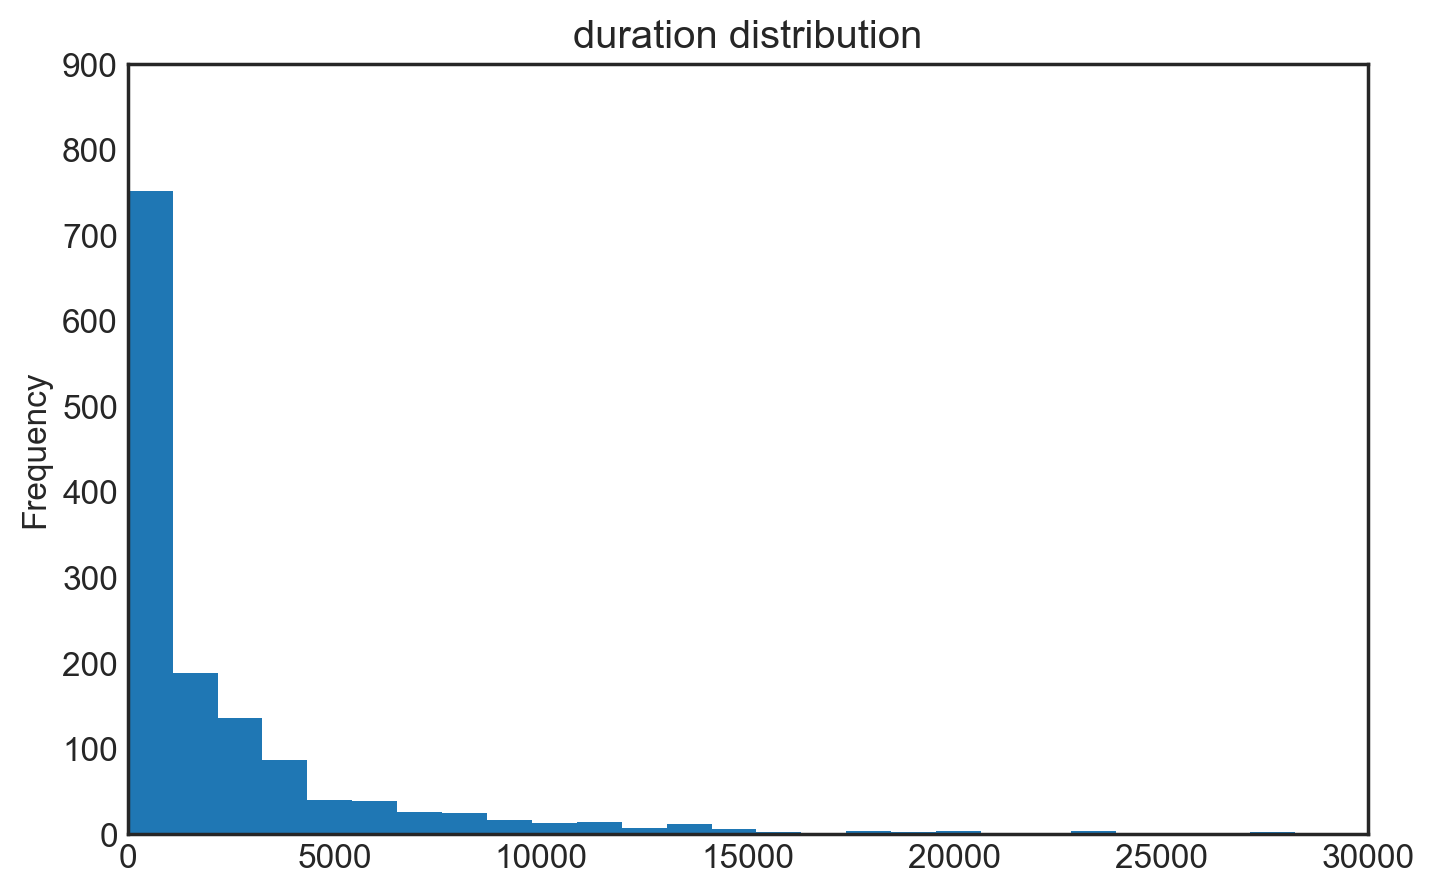

In [313]:
#Univariate Analysis: 
df['OUTAGE.DURATION'].plot.hist(bins = 100, title = 'duration distribution')
plt.ylim(0, 900)
plt.xlim(0,30000)

<AxesSubplot:title={'center':'climate category with amount of different length outage  '}, xlabel='bins'>

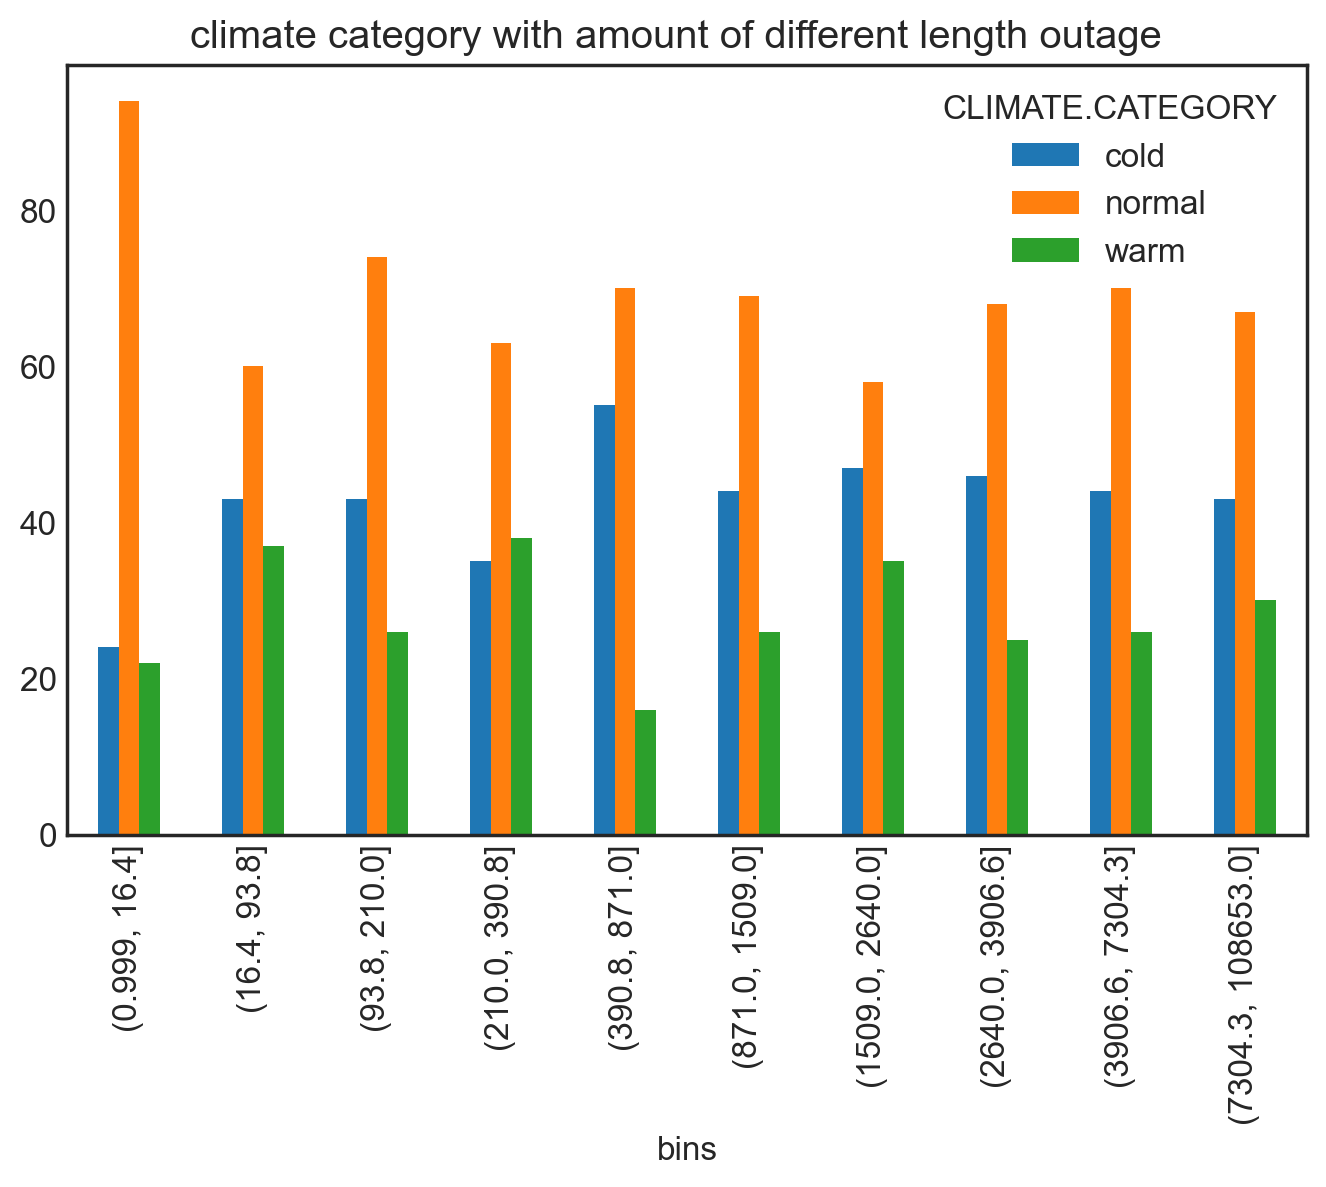

In [473]:
df['bins'] = pd.qcut(df['OUTAGE.DURATION'],q = 10)
pi = df.pivot_table(index = 'bins',
              columns = 'CLIMATE.CATEGORY',
              aggfunc = 'size')
pi.plot(kind = 'bar', label = " pivot_table histogram", title = 'climate category with amount of different length outage  ')

Text(0.5, 1.0, 'Scatter Plot of Bivariate Analysis')

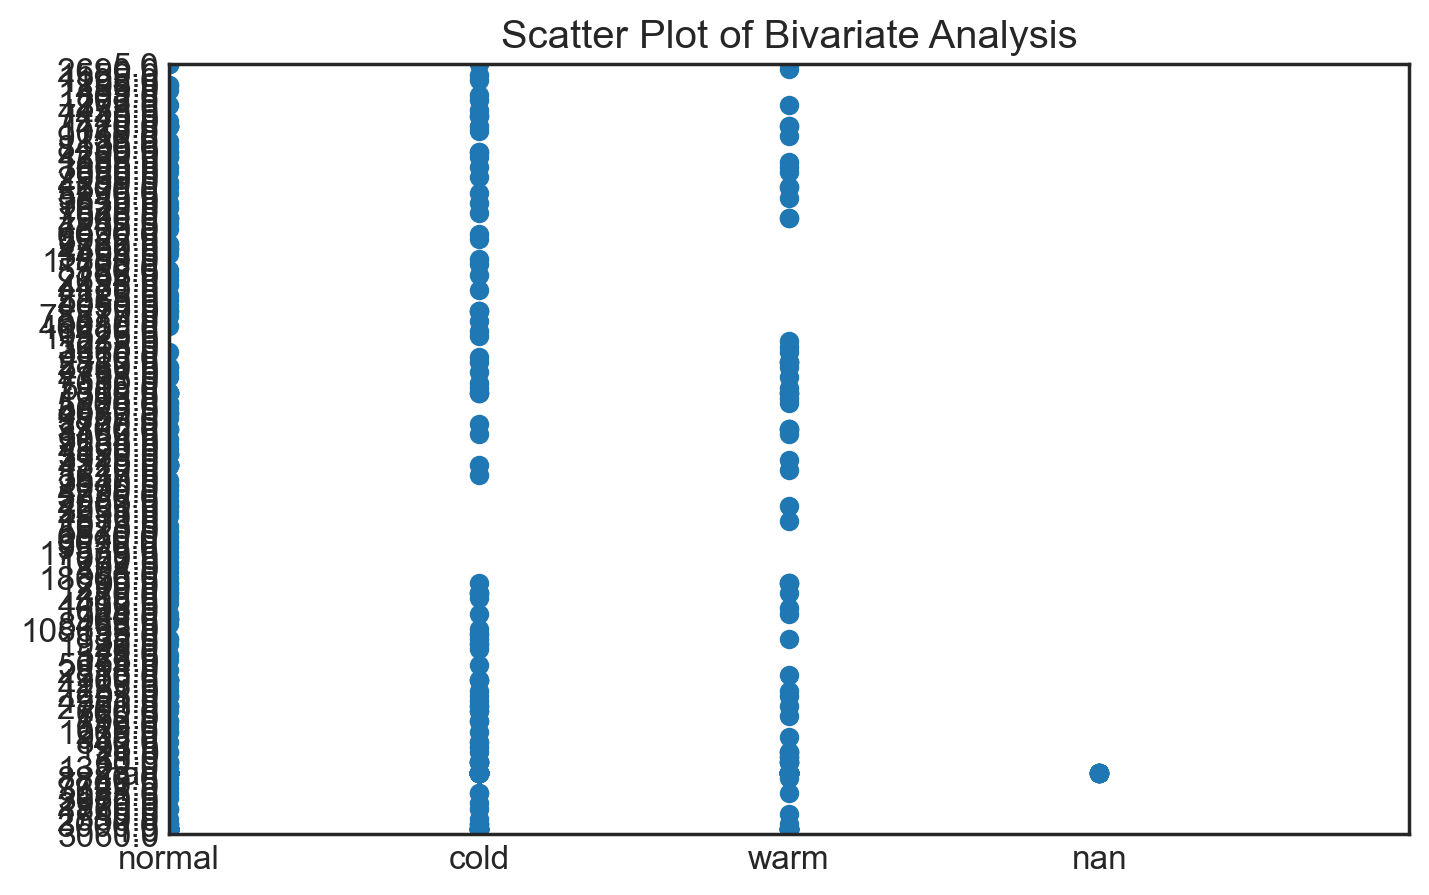

In [480]:
# df[['OUTAGE.DURATION','CLIMATE.CATEGORY']].plot.scatter(x= 'CLIMATE.CATEGORY',y = 'OUTAGE.DURATION' )
y  = df['OUTAGE.DURATION'].astype(str)
x = df['CLIMATE.CATEGORY'].astype(str)
plt.scatter(x,y)
plt.ylim(0, 150)
plt.xlim(0,4)
plt.title('Scatter Plot of Bivariate Analysis')

/Users/yanghede/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Aggregate Analysis Climate/Duration'}, xlabel='OUTAGE.DURATION', ylabel='Frequency'>

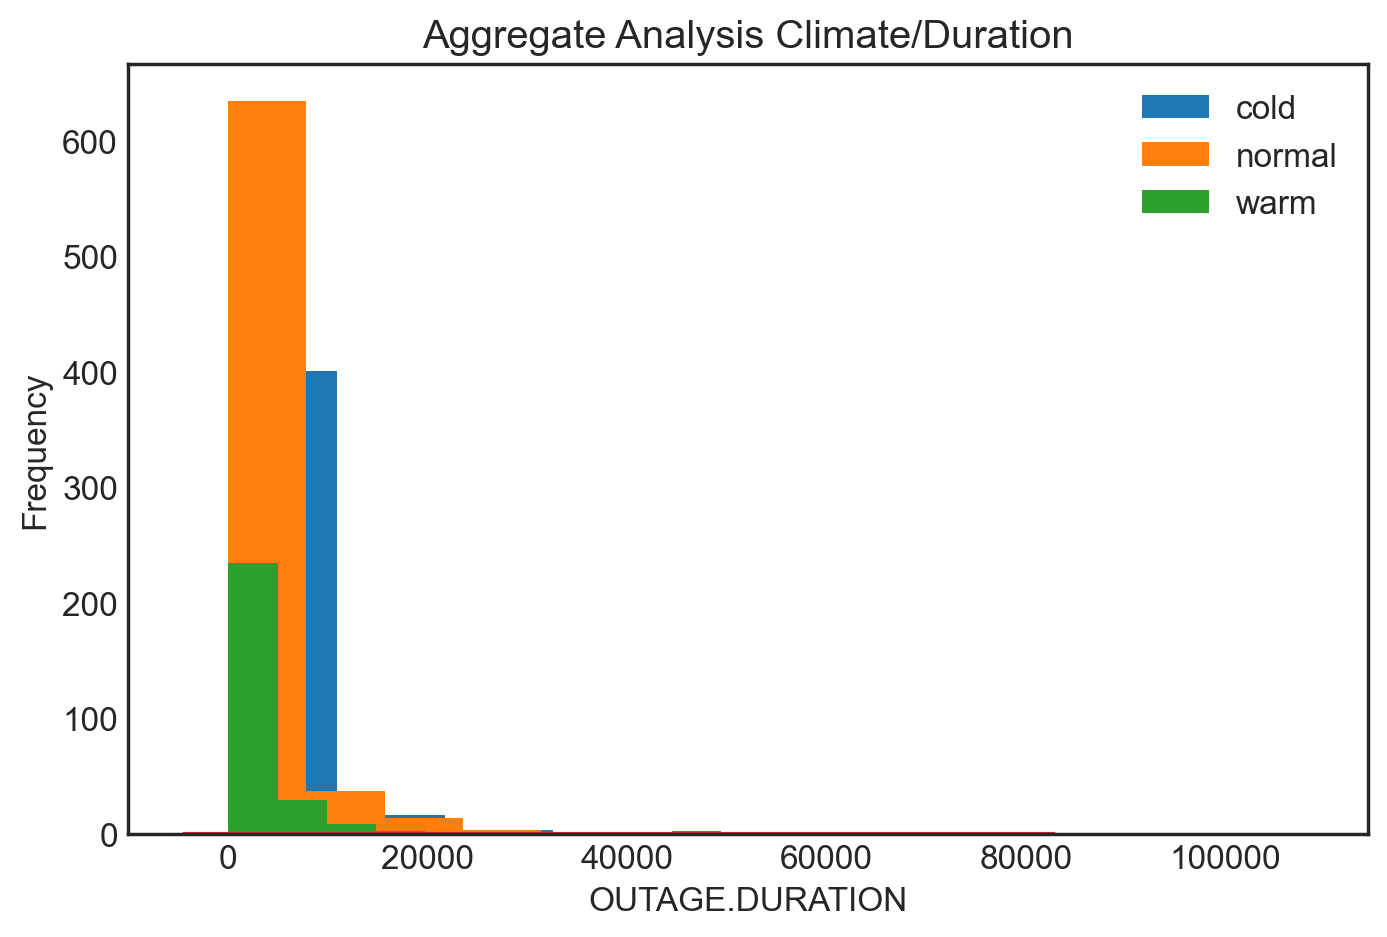

In [481]:
## eda aggregate analysis (frequency)
df.groupby('CLIMATE.CATEGORY')['OUTAGE.DURATION'].plot(kind = 'hist',legend = True, title = "Aggregate Analysis Climate/Duration")
sns.distplot(df.loc[df['CLIMATE.CATEGORY']== 'normal']['OUTAGE.DURATION'])



CLIMATE.CATEGORY
cold      AxesSubplot(0.125,0.11;0.775x0.77)
normal    AxesSubplot(0.125,0.11;0.775x0.77)
warm      AxesSubplot(0.125,0.11;0.775x0.77)
Name: OUTAGE.DURATION, dtype: object

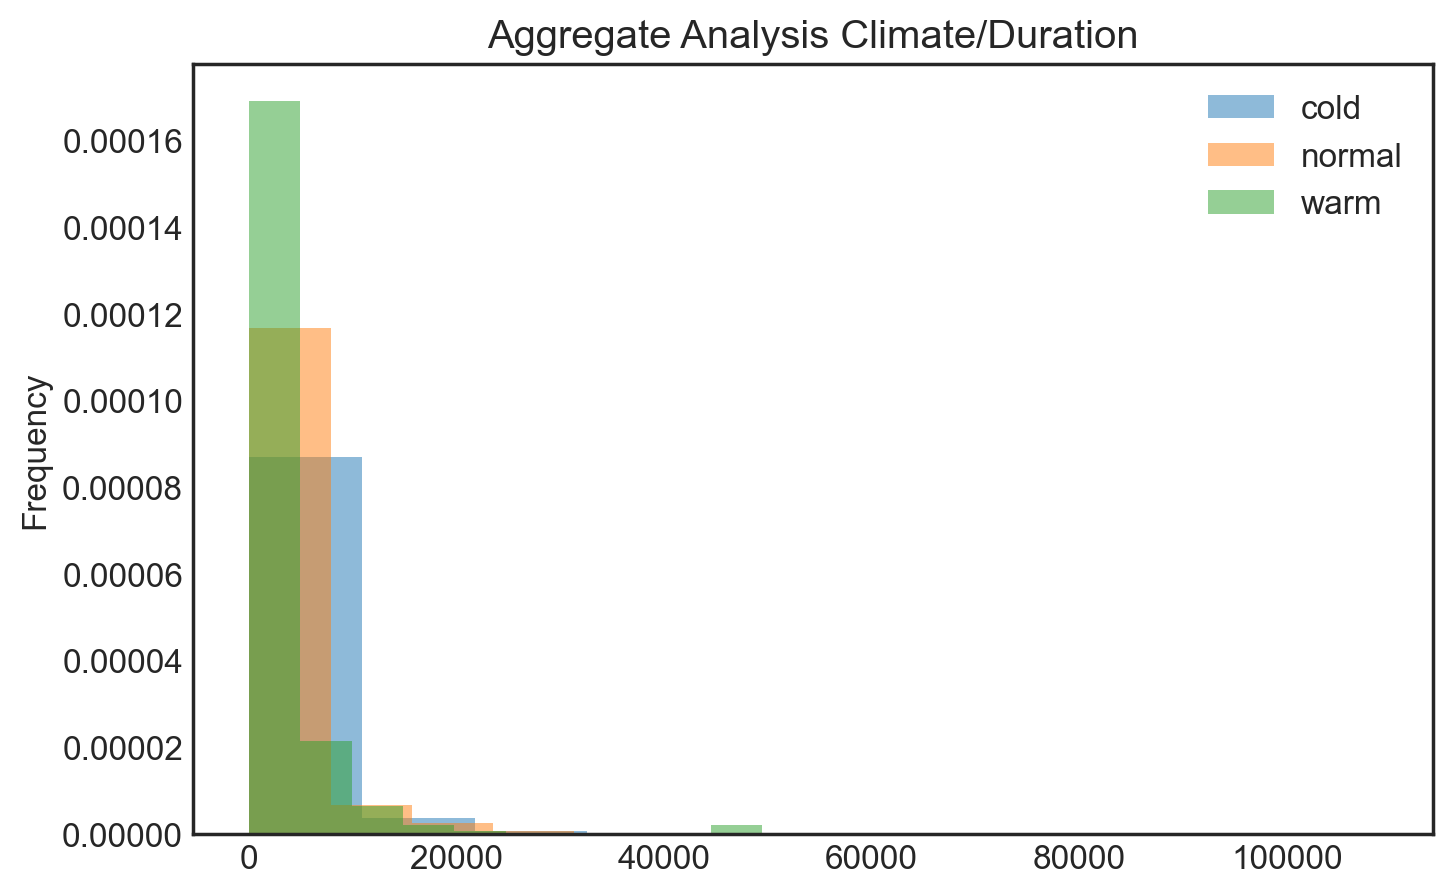

In [482]:
## eda aggregate analysis (density)
df.groupby('CLIMATE.CATEGORY')['OUTAGE.DURATION'].plot(kind = 'hist',alpha = 0.5, density = True, legend = True, title = "Aggregate Analysis Climate/Duration")

<AxesSubplot:title={'center':'Aggregate Analysis Climate/Duration'}, xlabel='CLIMATE.CATEGORY'>

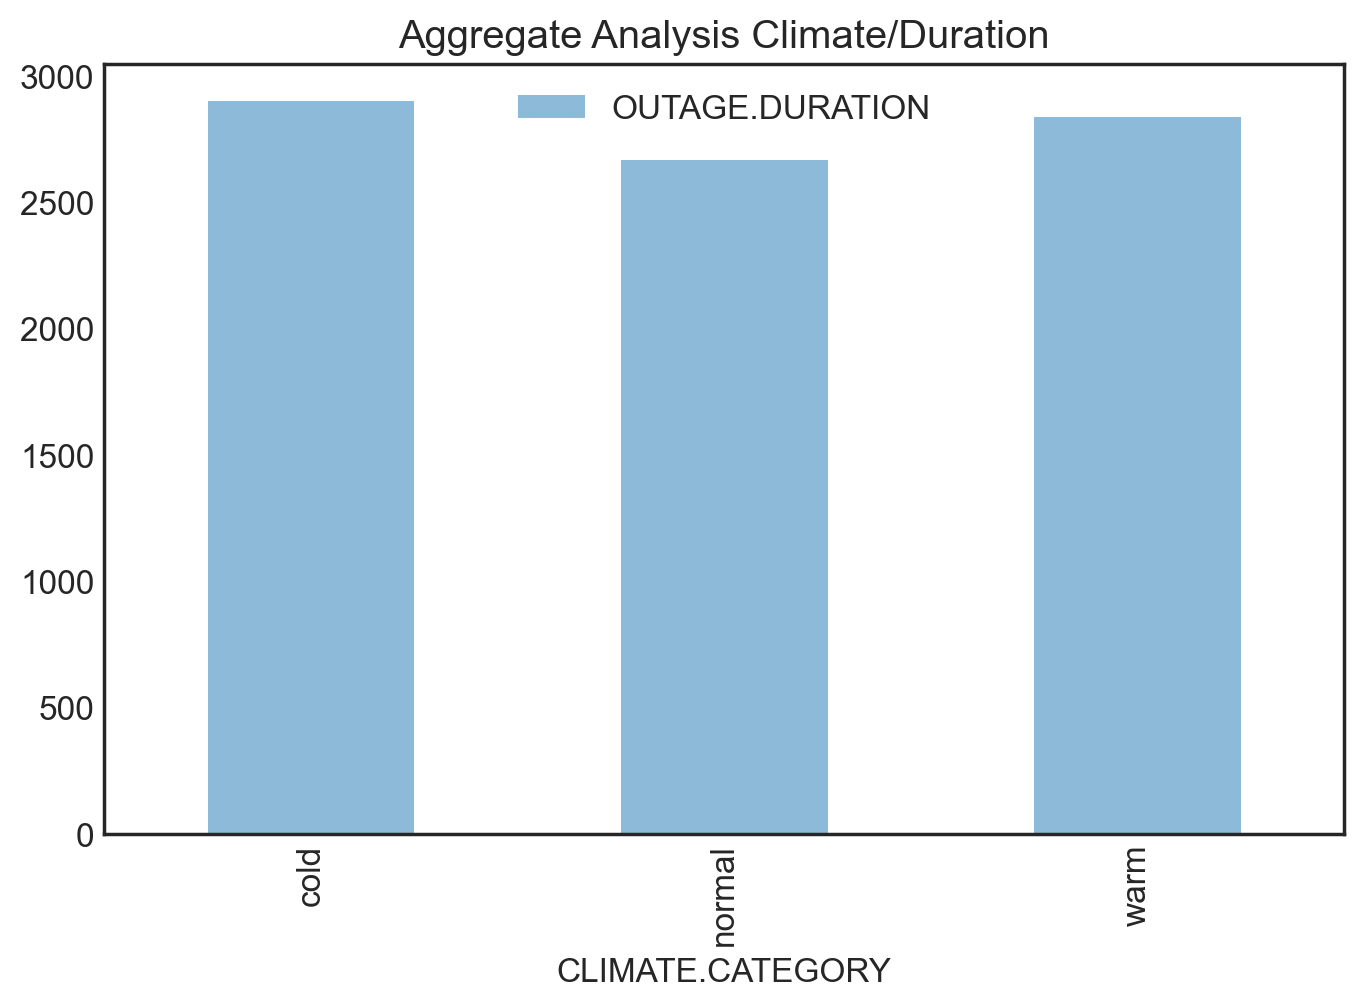

In [490]:
## eda aggregate analysis 
df.groupby('CLIMATE.CATEGORY')['OUTAGE.DURATION'].mean().plot(kind = 'bar',alpha = 0.5, legend = True, title = "Aggregate Analysis Climate/Duration")




/Users/yanghede/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yanghede/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yanghede/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

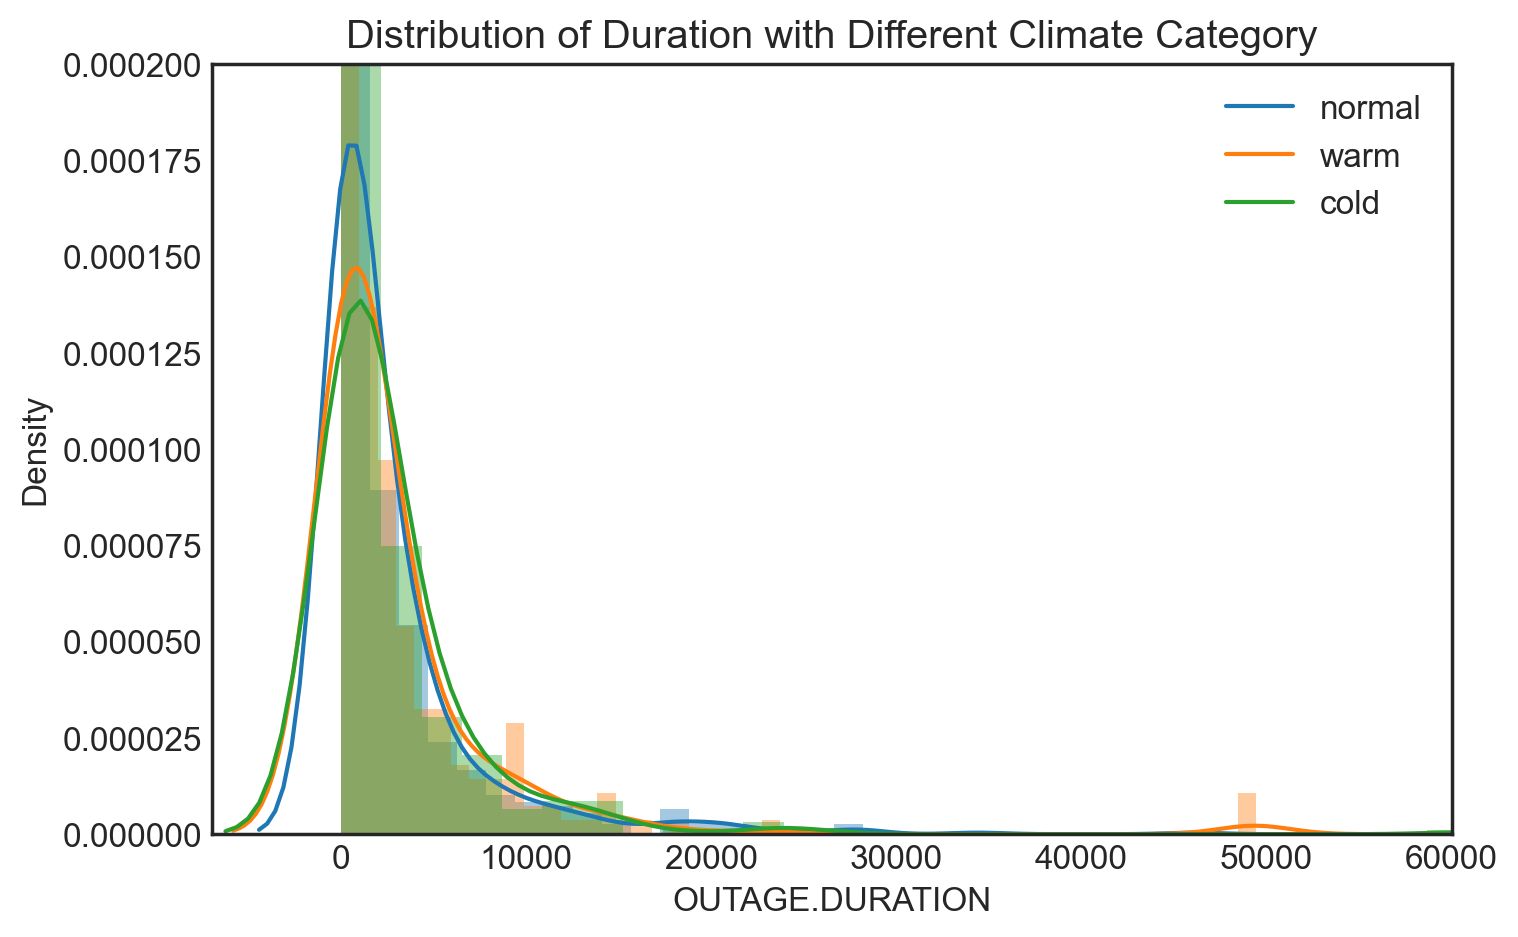

In [479]:
df1 = df[["CLIMATE.CATEGORY", "OUTAGE.DURATION"]]
df1 = df1.dropna()
normal = df1[df1["CLIMATE.CATEGORY"] == "normal"]
warm = df1[df1["CLIMATE.CATEGORY"] == "warm"] 
cold = df1[df1["CLIMATE.CATEGORY"] == "cold"] 
sns.distplot(normal["OUTAGE.DURATION"]) 
sns.distplot(warm["OUTAGE.DURATION"])
sns.distplot(cold["OUTAGE.DURATION"])
plt.legend(["normal", "warm","cold"])
plt.xlim([-7000, 60000])
plt.ylim([0, 0.0002])
plt.title("Distribution of Duration with Different Climate Category");

### Assessment of Missingness

### Hypothesis Test

#### Question: If cold climate is more likely to have a longer duration. 

#### Null Hypothesis: cold climate outage have average duration with non cold climate. 

#### Alternative hypothesis: cold climate tends to have longer average duration compare with other climate. 

#### The test statistic that we chose is to observe the Difference in Mean for cold climate outage and non-cold climate outage. We are using mean in difference because it provides a clear result of the difference between duration between different climate, whcih directly answered our question. We set the confidence interval at 0.05 



In [484]:
### insert a column that seperate cold climate and the rest of the climate
df['cold'] = df['CLIMATE.CATEGORY'] ==  'cold'
##keeping the columns that we need
df1 = df.copy()[['cold','CLIMATE.CATEGORY','OUTAGE.DURATION']]
df1.head()

,cold,CLIMATE.CATEGORY,OUTAGE.DURATION
0,False,normal,3060.0
1,False,normal,1.0
2,True,cold,3000.0
3,False,normal,2550.0
4,False,warm,1740.0


## Stimulation for 200 times

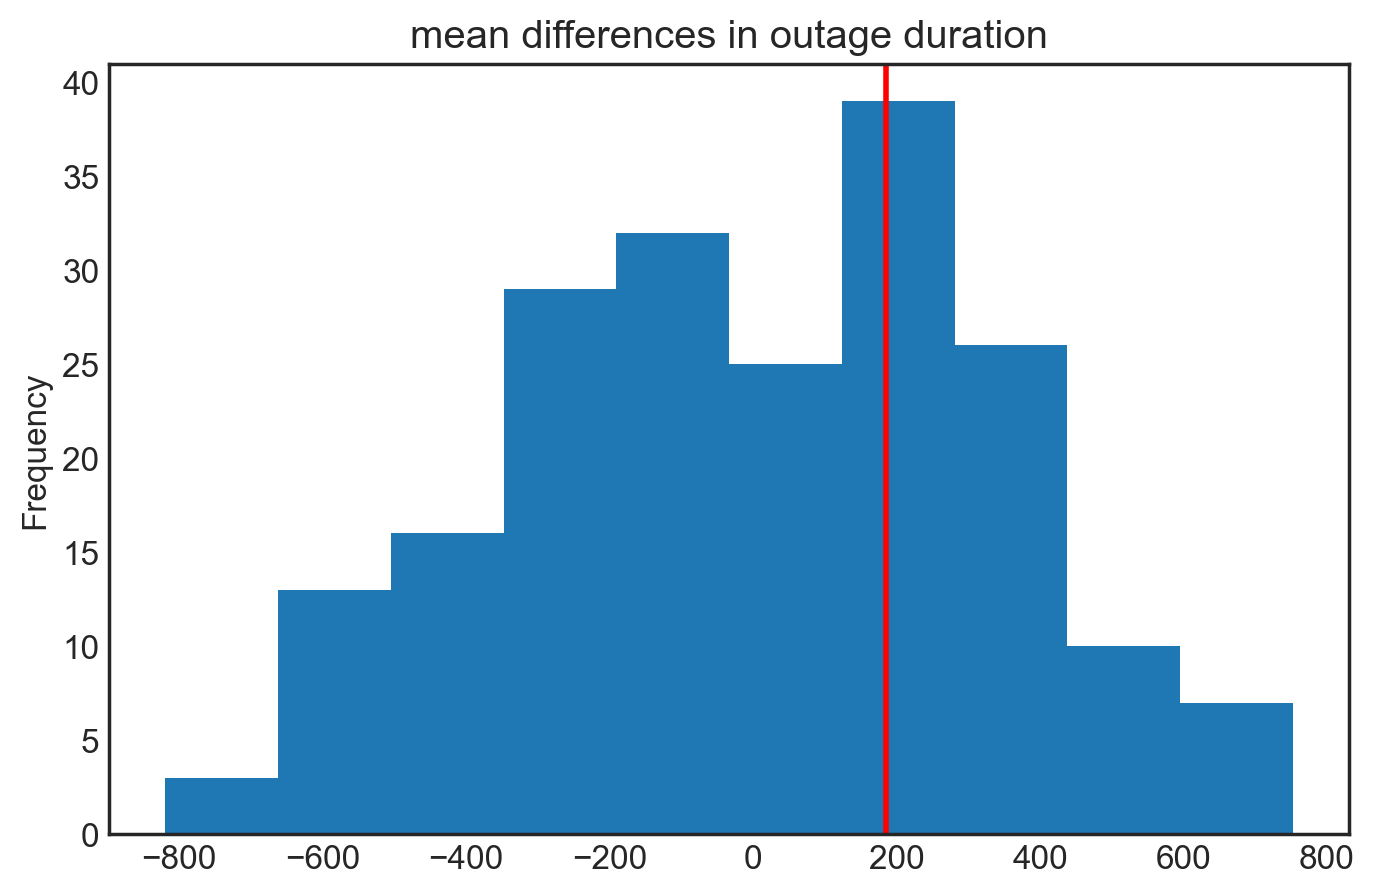

In [470]:
## find the mean diff between cold and non-cold
obs = df1.groupby('cold')['OUTAGE.DURATION'].mean().diff().iloc[-1]

## Stimulation 200 times 
diff = []
mean_diff = []

for i in range(200):

    random.shuffle(df1['OUTAGE.DURATION'])
    # df1.groupby('cold')['OUTAGE.DURATION'].mean()
    #     diff.append(df1.groupby('cold')['OUTAGE.DURATION'].mean().diff().iloc[-1])
    # diff
    diff.append(df1.groupby('cold')['OUTAGE.DURATION'].mean().diff().iloc[-1])
pd.Series(diff).plot(kind = 'hist',title = "mean differences in outage duration")
plt.axvline(x=obs, color='red', linewidth=2, );

#### the observed statistic lays within the distribution of mean difference distribution. It seems to be in the reasonal range. 

### P-Value 

In [471]:

p_val = np.mean(obs > diff)
p_val

0.675

### Conclusion: 
We end up fail to reject the null hypothesis of cold climate outage have average duration with non cold climate according to our hypothesis test of whether cold climate related to longer average outage duration. We set the significant level at 0.01 and the p-value that we got from hypothesis test is 0.675, which falls into the confidence interval. Thus cold climate have relative same average outage duration with non-cold climate. 

In [485]:
# from scipy.stats import ks_2samp
# a = df1.loc[df1['cold']==True,'OUTAGE.DURATION']
# b =df1.loc[df1['cold']==False,'OUTAGE.DURATION']
# obs_ks = ks_2samp(a, b).statistic
# obs_ks

0.09202296289949448

In [489]:
# n_repetitions = 500
# shuffled = df1.copy()
# ks_stats = []
# for _ in range(n_repetitions):
#     # Shuffling the data and assigning it back to the DataFrame
#     shuffled['OUTAGE.DURATION'] = np.random.permutation(df1['OUTAGE.DURATION'])
#     # Computing and storing the K-S statistic
#     groups = shuffled.groupby('cold')['OUTAGE.DURATION']
#     ks_stat = ks_2samp(groups.get_group(True), groups.get_group(False)).statistic
#     ks_stats.append(ks_stat)
# pval = np.mean(np.array(ks_stats) >= obs_ks)

# pd.Series(ks_stats).plot(kind='hist', density=True, ec='w', title=f'p-value: {pval}', label='Simulated K-S Statistics')
# plt.axvline(diff, color='red', label='Observed K-S Statistic')